In [1]:
# PYTORCH IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# OTHER USEFUL PYTHON MODULES AND PACKAGES
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
import imageio
import flappy_bird_gym

# BASE PYTHON IMPORTS
import random
from collections import deque, namedtuple
from itertools import count
import time
from pathlib import Path


# SET UP MATPLOTLIB
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [2]:
# run this cell if matplotlib causes python kernel dead
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# # check your environment
# import sys
# print(sys.executable)
# print(torch.__file__) 
# print(torch.cuda.is_available())
# from torch.utils import collect_env
# print(collect_env.main())

In [4]:
# install and import the flappy-bird-gym env
# pip install flappy-bird-gym

In [5]:
env = flappy_bird_gym.make("FlappyBird-v0")
state, info = env.reset()

# Convert state to 1D numpy array
state = np.array(state).flatten()

# Print the number of observation features
print('# Observation Features:', len(state), '\n')

# Print the number of possible actions
print('# Possible Actions:', env.action_space.n, '\n')

# Print the initial observation
print('Initial Observation:', '\n')
print(state, '\n')

# Print the type of the observation array
print('Observation array is of type:', type(state))

env.close()

# Observation Features: 1 

# Possible Actions: 2 

Initial Observation: 

[1.65625] 

Observation array is of type: <class 'numpy.ndarray'>


## Define the model class DQN

In [6]:
class DQN(nn.Module):

    # DEFINE THE SPECIAL INIT METHOD
    def __init__(self, features, hidden, output):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(features, hidden[0])
        self.linear2 = nn.Linear(hidden[0], hidden[1])
        self.linear3 = nn.Linear(hidden[1], output)
        
    # DEFINE THE FORWARD METHOD
    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = F.relu(self.linear2(out))
        y_pred = self.linear3(out)
        return y_pred

## Replay Memory

In [7]:
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
    )


class ReplayMemory(object):
    """
    A class to store gym transitions
    """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Function select action

In [8]:
def eps_decay(steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    return eps_threshold

In [9]:
def select_action(state, eps):

    num_actions = 2  # Add this line

    with torch.no_grad():
        q_values = policy_net(state)
        if random.random() > eps:
            # Take the action with the highest Q-value
            action = q_values.argmax().unsqueeze(0)
        else:
            # Take a random action
            action = torch.tensor([random.randrange(num_actions)], device=device)
    return action

## Define function to optimize the model

In [10]:
def optimize_model():

    # CHECK THE LENGTH OF THE REPLAY MEMORY, RETURN NONE IF LENGTH LESS THAN
    # THE BATCH_SIZE
    if len(memory) < BATCH_SIZE:
        return 0
    
    # SAMPLE N TRANSITIONS FROM THE REPLAY MEMORY, WHERE N IS BATCH_SIZE
    transitions = memory.sample(BATCH_SIZE)

    # DEFINE THE BATCH AS TRANSITION NAMED TUPLE, THIS SPLITS state's, 
    # action's, next_state's, and reward's into tuples see the following link
    # https://stackoverflow.com/a/19343/3343043
    batch = Transition(*zip(*transitions))

    # FIND THE INDICES OF TRANSITIONS THAT ARE NON-TERMINAL STATES
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device, 
        dtype=torch.bool
        )
    
    # FIND THAT STATES THAT ARE NON-TERMINAL STATES
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
        )
    

    ### CREATE 3 TENSORS ONE FOR THE STATES, ACTIONS AND REWARDS
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action).unsqueeze(1)
    reward_batch = torch.cat(batch.reward)


    # GET THE ACTION VALUES OF POLICY NET FOR EACH ACTION WHICH WAS TAKEN
    # HERE YOU SHOULD USE tensor.gather() METHOD SO YOU CAN SPECIFY WHICH 
    # ACTION WE ARE INTERESTED IN. WE ONLY WANT THE ACTION WHICH WAS TAKEN
    # FOR THE TRANSACTION
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # CREATE TENSOR OF ZEROS TO STORE THE NEXT STATE VALUES WITH torch.zeros()
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    # DO NOT CALCULATE GRADIENTS
    with torch.no_grad():

        # DEFINE THE NEXT STATE Q VALUES USING THE TARGET NET - max(Q_target(s', a'))
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        
    # COMPUTE EXPECTED RETURN Y = Discount*max(Q_target(s',a)) + Reward 
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # DEFINE THE HUBER LOSS
    criterion = nn.SmoothL1Loss()

    # CALCULATE THE LOSS L(Q_policy(s,a), Y)
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # ZERO THE GRADIENTS
    optimizer.zero_grad()

    # PROPAGATE GRADIENT THROUGH NETWORK 
    loss.backward()

    # IN PLACE GRADIENT CLIPPING
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    # TAKE AN OPTIMIZER STEP
    optimizer.step()

    return 1

## Helper functions to show training progess
The plot shows moving average of rewards for the 10 most recent episodes

In [11]:
episode_durations = []
episode_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def plot_rewards(show_result=False):
    # SET THE CURRENT FIGURE
    plt.figure(1)

    # IF TRAINING IS COMPLETE
    if show_result:
        plt.title(f'MA10 Result (Episode {i_episode + 1}Highest Reward: {max(episode_rewards)})')
    
    # IF STILL TRAINING   
    else:
        plt.clf()
        plt.title(f'Training... Eps: {i_episode + 1} Current Reward: {cum_reward} Highest Reward: {max(episode_rewards)}')
    
    # SET LABELS AND PLOT DATA
    plt.xlabel('Episode')
    plt.ylabel('Average Reward (Last 10 Episodes)')
    cumulative_average_rewards = np.convolve(episode_rewards, np.ones(10)/10, mode='valid')
    plt.plot(cumulative_average_rewards)
    # PAUSE SO THAT PLOTS CAN BE UPDATED
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            # WAIT UNTIL NEW OUTPUT AVAILABLE TO CLEAR CURRENT FIGURE
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Define the model and training parameters


In [12]:
# Define the environment
env = flappy_bird_gym.make("FlappyBird-v0")

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define all the scalar constants
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.0001
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-4
HIDDEN = 64
MEMORY = 50000

# Get the number of actions from the environment
n_actions = env.action_space.n

# Reset the environment
state = env.reset()

# Get the number of features in a state
n_features = state.shape[0]

# Define the policy and target net as instances of the DQN model
policy_net = DQN(n_features, [HIDDEN, HIDDEN], n_actions).to(device)
target_net = DQN(n_features, [HIDDEN, HIDDEN], n_actions).to(device)

# Sync the weights of the target and policy nets
target_net.load_state_dict(policy_net.state_dict())

# Define the optimizer - use AdamW with amsgrad=True
optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Define the replay memory as an instance of ReplayMemory
replay_buffer = ReplayMemory(MEMORY)

In [13]:
# # TEST THE MODEL
# ini_state = [1.0, 2.0]
# state = ini_state
# state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
# # Define the policy and target net as instances of the updated DQN model
# policy_net = DQN(n_features, [HIDDEN, HIDDEN], n_actions).to(device)
# target_net = DQN(n_features, [HIDDEN, HIDDEN], n_actions).to(device)

# # Sync the weights of the target and policy nets
# target_net.load_state_dict(policy_net.state_dict())

# print('The observation:\n')
# print(state_tensor.to(device), '\n')

# print('The policy net predictions:\n')
# with torch.no_grad():
#     q_values = policy_net(state_tensor.to(device))
#     print(q_values, '\n')
#     action = q_values.argmax().item()
#     print('Action:', action, '\n')

# print('Using the select action function:', '\n')
# action = select_action(state_tensor.to(device), eps=0)
# print('Action:', action)

## Define Training Loop

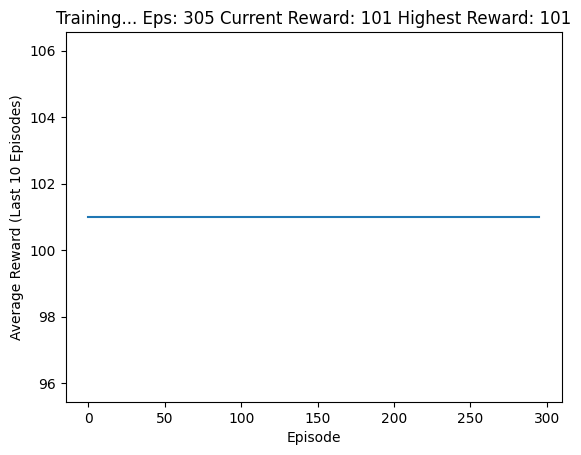

<Figure size 640x480 with 0 Axes>

In [14]:
# CHECK IF CUDA IS AVAILABLE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATA STRUCTURES TO STORE RELEVANT DATA FOR FUTURE PLOTS
episode_durations = []
episode_rewards = []
total_transitions = 0
start_time = time.time()
num_episodes = 1000
memory = ReplayMemory(MEMORY)

# PERFORM SET NUMBER OF EPISODES
for i_episode in range(num_episodes):

    # START THE ENVIRONMENT AND OBSERVE THE STATE
    state = env.reset()

    # CONVERT THE 8 ELEMENT ARRAY TO TORCH TENSOR AND MOVE TO DEVICE
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    cum_reward = 0
    
    # FOR EVERY TRANSITION IN THE EPISODE (ITERATES UNTIL TERMINAL STATE)
    for t in count():
        
        # UPDATE TOTAL TRANSITIONS COUNTER
        total_transitions += 1

        # CALCULATE EPS USING TOTAL TRANSITIONS
        eps = eps_decay(total_transitions)

        # SELECT AN ACTION USING THE TARGET NETWORK - select_action() FUNCTION
        action = select_action(state, eps=eps)

        # OBSERVE THE TRANSITION
        observation, reward, done, _ = env.step(action.item())
        cum_reward += reward
        reward = torch.tensor([reward], device=device)

        # DEFINE THE NEXT STATE OF THE ENVIRONMENT
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # PUSH THE TRANSITION INTO THE REPLAY MEMORY
        memory.push(state, action, next_state, reward)

        # STORE THE NEXT STATE AS CURRENT STATE FOR NEXT ITERATION
        state = next_state

        # OPTIMIZE THE MODEL (UPDATE THE WEIGHTS OF THE POLICY NET)
        optimize_model()

        # GET THE CURRENT WEIGHTS OF EACH NETWORK
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        # CALCULATE SOFT UPDATE OF TARGET NET WEIGHTS
        # θ′ ← τ θ + (1 −τ )θ′
        for key in policy_net_state_dict:
            # MOVE THE POLICY_NET_STATE_DICT TENSOR TO THE CPU DEVICE
            policy_net_state_dict[key] = policy_net_state_dict[key].to(device)
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net_state_dict[key] = target_net_state_dict[key].to(device)

        # APPLY THE UPDATE TO THE TARGET NETWORK
        target_net.load_state_dict(target_net_state_dict)


        # IF THE EPISODE IS COMPLETE BREAK INNER LOOP
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(cum_reward)
            # plot_durations()
            plot_rewards()
            break

print('Complete')
end_time = time.time()
plot_rewards(show_result=True)
plt.ioff()
plt.show()

In [ ]:
print(end_time - start_time)

7656.7445821762085


## Save and Check The Results

In [ ]:
path = Path('./models/flappy_bird_dqn_linear_1.pth')
torch.save(policy_net, './models/flappy_bird_dqn_linear_1.pth')

In [ ]:
# Set up the Flappy Bird environment
env = flappy_bird_gym.make("FlappyBird-v0")

# Set up the DQN policy network
input_dim = 2  # Replace with the actual input dimensions for your environment
output_dim = env.action_space.n
hidden_dim = 64

# Play the game using the trained policy network for 20 episodes
num_episodes = 20
episode_rewards = []

for i_episode in range(num_episodes):
    state = env.reset()
    cum_reward = 0

    while True:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = policy_net(state)
        action = q_values.argmax(dim=1).item()
        state, reward, done, _ = env.step(action)
        cum_reward += reward

        if done:
            episode_rewards.append(cum_reward)
            print("Episode {}: Cumulative Reward = {}".format(i_episode+1, cum_reward))
            break

# Print the average rewards over 20 episodes
avg_reward = sum(episode_rewards) / len(episode_rewards)
print("Average Reward over 20 Episodes = {:.2f}".format(avg_reward))

Episode 1: Cumulative Reward = 101
Episode 2: Cumulative Reward = 101
Episode 3: Cumulative Reward = 82
Episode 4: Cumulative Reward = 101
Episode 5: Cumulative Reward = 101
Episode 6: Cumulative Reward = 101
Episode 7: Cumulative Reward = 85
Episode 8: Cumulative Reward = 101
Episode 9: Cumulative Reward = 101
Episode 10: Cumulative Reward = 101
Episode 11: Cumulative Reward = 101
Episode 12: Cumulative Reward = 101
Episode 13: Cumulative Reward = 101
Episode 14: Cumulative Reward = 101
Episode 15: Cumulative Reward = 101
Episode 16: Cumulative Reward = 101
Episode 17: Cumulative Reward = 101
Episode 18: Cumulative Reward = 101
Episode 19: Cumulative Reward = 101
Episode 20: Cumulative Reward = 101
Average Reward over 20 Episodes = 99.25


In [ ]:
# Load the model
#policy_net = torch.load('./models/flappy_bird_dqn_linear_1.pth')

## Improve the DQN network

In [18]:
class enhancedDQN(nn.Module):
    def __init__(self, n_features, hidden, n_actions, p=0.1):
        super(enhancedDQN, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden[0])
        self.drop1 = nn.Dropout(p)
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.drop2 = nn.Dropout(p)
        self.fc3 = nn.Linear(hidden[1], n_actions)

    def forward(self, x):
        x = F.relu(self.drop1(self.fc1(x)))
        x = F.relu(self.drop2(self.fc2(x)))
        x = self.fc3(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0.1)


In [19]:
def optimize_model():

    # CHECK THE LENGTH OF THE REPLAY MEMORY, RETURN NONE IF LENGTH LESS THAN
    # THE BATCH_SIZE
    if len(memory) < BATCH_SIZE:
        return 0
    
    # SAMPLE N TRANSITIONS FROM THE REPLAY MEMORY, WHERE N IS BATCH_SIZE
    transitions = memory.sample(BATCH_SIZE)

    # DEFINE THE BATCH AS TRANSITION NAMED TUPLE, THIS SPLITS state's, 
    # action's, next_state's, and reward's into tuples see the following link
    # https://stackoverflow.com/a/19343/3343043
    batch = Transition(*zip(*transitions))

    # FIND THE INDICES OF TRANSITIONS THAT ARE NON-TERMINAL STATES
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device, 
        dtype=torch.bool
        )
    
    # FIND THAT STATES THAT ARE NON-TERMINAL STATES
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
        )
    

    ### CREATE 3 TENSORS ONE FOR THE STATES, ACTIONS AND REWARDS
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action).unsqueeze(1)
    reward_batch = torch.cat(batch.reward)


    # GET THE ACTION VALUES OF POLICY NET FOR EACH ACTION WHICH WAS TAKEN
    # HERE YOU SHOULD USE tensor.gather() METHOD SO YOU CAN SPECIFY WHICH 
    # ACTION WE ARE INTERESTED IN. WE ONLY WANT THE ACTION WHICH WAS TAKEN
    # FOR THE TRANSACTION
    state_action_values = policy_net(state_batch)

    # CREATE TENSOR OF ZEROS TO STORE THE NEXT STATE VALUES WITH torch.zeros()
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    # DO NOT CALCULATE GRADIENTS
    with torch.no_grad():

        # DEFINE THE NEXT STATE Q VALUES USING THE TARGET NET - max(Q_target(s', a'))
        next_state_actions = policy_net(non_final_next_states)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # COMPUTE EXPECTED RETURN Y = Discount*max(Q_target(s',a)) + Reward 
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # DEFINE THE HUBER LOSS
    criterion = nn.SmoothL1Loss()

    # CALCULATE THE LOSS L(Q_policy(s,a), Y)
    loss = criterion(state_action_values.gather(1, action_batch), expected_state_action_values.unsqueeze(1))

    # ZERO THE GRADIENTS
    optimizer.zero_grad()

    # PROPAGATE GRADIENT THROUGH NETWORK 
    loss.backward()

    # IN PLACE GRADIENT CLIPPING
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)

    # TAKE AN OPTIMIZER STEP
    optimizer.step()

    return 1

In [20]:
# Define the environment
env = flappy_bird_gym.make("FlappyBird-v0")

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define all the scalar constants
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.1
EPS_END = 0.0001
EPS_DECAY = 100000
TAU = 0.005
LR = 0.001
HIDDEN = 256
MEMORY = 100000

# Get the number of actions from the environment
n_actions = env.action_space.n

# Reset the environment
state = env.reset()

# Get the number of features in a state
n_features = state.shape[0]

# Define the policy and target net as instances of the updated DQN model
policy_net = enhancedDQN(n_features, [HIDDEN, HIDDEN], n_actions).to(device)
target_net = enhancedDQN(n_features, [HIDDEN, HIDDEN], n_actions).to(device)

# Sync the weights of the target and policy nets
target_net.load_state_dict(policy_net.state_dict())

# Define the optimizer - use AdamW with amsgrad=True
optimizer = torch.optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Define the replay memory as an instance of ReplayMemory
replay_buffer = ReplayMemory(MEMORY)

In [21]:
# # TEST THE MODEL
# ini_state = [1.0, 2.0]
# state = ini_state
# state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
# # Define the policy and target net as instances of the updated DQN model
# policy_net = enhancedDQN(n_features, [HIDDEN, HIDDEN], n_actions).to(device)
# target_net = enhancedDQN(n_features, [HIDDEN, HIDDEN], n_actions).to(device)

# # Sync the weights of the target and policy nets
# target_net.load_state_dict(policy_net.state_dict())

# print('The observation:\n')
# print(state_tensor.to(device), '\n')

# print('The policy net predictions:\n')
# with torch.no_grad():
#     q_values = policy_net(state_tensor.to(device))
#     print(q_values, '\n')
#     action = q_values.argmax().item()
#     print('Action:', action, '\n')

# print('Using the select action function:', '\n')
# action = select_action(state_tensor.to(device), eps=0)
# print('Action:', action)

Complete


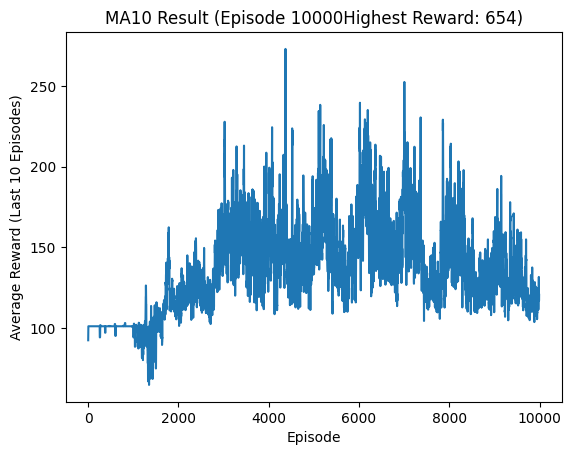

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

12598.60365319252


In [22]:
# CHECK IF CUDA IS AVAILABLE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATA STRUCTURES TO STORE RELEVANT DATA FOR FUTURE PLOTS
episode_durations = []
episode_rewards = []
total_transitions = 0
start_time = time.time()
num_episodes = 10000
memory = ReplayMemory(MEMORY)

# PERFORM SET NUMBER OF EPISODES
for i_episode in range(num_episodes):

    # START THE ENVIRONMENT AND OBSERVE THE STATE
    state = env.reset()

    # CONVERT THE 8 ELEMENT ARRAY TO TORCH TENSOR AND MOVE TO DEVICE
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    cum_reward = 0
    
    # FOR EVERY TRANSITION IN THE EPISODE (ITERATES UNTIL TERMINAL STATE)
    for t in count():
        
        # UPDATE TOTAL TRANSITIONS COUNTER
        total_transitions += 1

        # CALCULATE EPS USING TOTAL TRANSITIONS
        eps = eps_decay(total_transitions)

        # SELECT AN ACTION USING THE TARGET NETWORK - select_action() FUNCTION
        action = select_action(state, eps=eps)

        # OBSERVE THE TRANSITION
        observation, reward, done, _ = env.step(action.item())
        cum_reward += reward
        reward = torch.tensor([reward], device=device)
        
        if reward < 0:
            done = True
            
        # DEFINE THE NEXT STATE OF THE ENVIRONMENT
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # PUSH THE TRANSITION INTO THE REPLAY MEMORY
        memory.push(state, action, next_state, reward)

        # STORE THE NEXT STATE AS CURRENT STATE FOR NEXT ITERATION
        state = next_state

        # OPTIMIZE THE MODEL (UPDATE THE WEIGHTS OF THE POLICY NET)
        optimize_model()

        # GET THE CURRENT WEIGHTS OF EACH NETWORK
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        # CALCULATE SOFT UPDATE OF TARGET NET WEIGHTS
        # θ′ ← τ θ + (1 −τ )θ′
        for key in policy_net_state_dict:
            # MOVE THE POLICY_NET_STATE_DICT TENSOR TO THE CPU DEVICE
            policy_net_state_dict[key] = policy_net_state_dict[key].to(device)
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net_state_dict[key] = target_net_state_dict[key].to(device)

        # APPLY THE UPDATE TO THE TARGET NETWORK
        target_net.load_state_dict(target_net_state_dict)


        # IF THE EPISODE IS COMPLETE BREAK INNER LOOP
        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(cum_reward)
            # plot_durations()
            plot_rewards()
            break

print('Complete')
end_time = time.time()
plot_rewards(show_result=True)
plt.ioff()
plt.show()
print(end_time - start_time)

In [23]:
path = Path('./models/flappy_bird_newdqn.pth')
torch.save(policy_net, './models/flappy_bird_newdqn.pth')

In [24]:
# Set up the Flappy Bird environment
env = flappy_bird_gym.make("FlappyBird-v0")

# Set up the DQN policy network
input_dim = 2  # Replace with the actual input dimensions for your environment
output_dim = env.action_space.n
hidden_dim = 64

# Play the game using the trained policy network for 20 episodes
num_episodes = 20
episode_rewards = []

for i_episode in range(num_episodes):
    state = env.reset()
    cum_reward = 0

    while True:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_values = policy_net(state)
        action = q_values.argmax(dim=1).item()
        state, reward, done, _ = env.step(action)
        cum_reward += reward

        if done:
            episode_rewards.append(cum_reward)
            print("Episode {}: Cumulative Reward = {}".format(i_episode+1, cum_reward))
            break

# Print the average rewards over 20 episodes
avg_reward = sum(episode_rewards) / len(episode_rewards)
print("Average Reward over 20 Episodes = {:.2f}".format(avg_reward))

Episode 1: Cumulative Reward = 116
Episode 2: Cumulative Reward = 228
Episode 3: Cumulative Reward = 179
Episode 4: Cumulative Reward = 143
Episode 5: Cumulative Reward = 137
Episode 6: Cumulative Reward = 174
Episode 7: Cumulative Reward = 174
Episode 8: Cumulative Reward = 212
Episode 9: Cumulative Reward = 107
Episode 10: Cumulative Reward = 121
Episode 11: Cumulative Reward = 174
Episode 12: Cumulative Reward = 148
Episode 13: Cumulative Reward = 103
Episode 14: Cumulative Reward = 226
Episode 15: Cumulative Reward = 154
Episode 16: Cumulative Reward = 156
Episode 17: Cumulative Reward = 108
Episode 18: Cumulative Reward = 190
Episode 19: Cumulative Reward = 137
Episode 20: Cumulative Reward = 187
Average Reward over 20 Episodes = 158.70
